In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import image as img

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import os
import random
from PIL import Image
import sys
from tqdm.notebook import tqdm
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

pip install pyttsx3

In [12]:
import pyttsx3

In [38]:
engine = pyttsx3.init()

In [13]:
# Reading the csv file into a dataframe

df = pd.read_csv('C:/Users/Hp/PycharmProjects/HAR/Training_set.csv')


In [14]:
df['label'].value_counts()

sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: label, dtype: int64

In [15]:
df= df.loc[(df["label"] == "sitting")|(df["label"] == "sleeping")| (df["label"] ==  "clapping")|  (df["label"] ==  "running")| (df["label"] ==  "eating")]
empty= pd.DataFrame()
pd.concat([empty,df], ignore_index=True)

empty.head()


""


In [16]:
df

,filename,label
0,Image_1.jpg,sitting
3,Image_4.jpg,sleeping
5,Image_6.jpg,sleeping
8,Image_9.jpg,clapping
12,Image_13.jpg,clapping
...,...,...
12592,Image_12593.jpg,clapping
12593,Image_12594.jpg,sleeping
12595,Image_12596.jpg,sitting
12596,Image_12597.jpg,clapping


In [17]:
# Checking the data types

df.dtypes

filename    object
label       object
dtype: object

In [18]:
# Checking for null values

df.isnull().sum()

filename    0
label       0
dtype: int64

In [19]:
# Checking label counts


counts = df['label'].value_counts()
counts


sitting     840
sleeping    840
clapping    840
eating      840
running     840
Name: label, dtype: int64

In [20]:
df['filename'][8]

'Image_9.jpg'

In [ ]:
# Function to display few random images

def displayRandom(n=1):
    plt.figure(figsize=(20,20))
    for i in range(n):
        rnd = random.randint(0,len(df)-1)
        img_file = '../input/human-action-recognition-har-dataset/Human Action Recognition/train/' + df['filename'][rnd]

        if os.path.exists(img_file):
            plt.subplot(n//2+1, 2, i + 1)
            image = img.imread(img_file)
            plt.imshow(image)
            plt.title(df['label'][rnd])


In [22]:
# Displaying 4 random images with corresponding label

displayRandom()

<Figure size 1440x1440 with 0 Axes>

In [23]:
# Label encoding and seperate dependant variable

lb = LabelBinarizer()
y = lb.fit_transform(df['label'])
classes = lb.classes_
print(classes)

['clapping' 'eating' 'running' 'sitting' 'sleeping']


In [24]:
# Take independant variable as numpy array

x = df['filename'].values
x

array(['Image_1.jpg', 'Image_4.jpg', 'Image_6.jpg', ...,
       'Image_12596.jpg', 'Image_12597.jpg', 'Image_12598.jpg'],
      dtype=object)

In [25]:
# Split data as 90% of training and 10% of test data

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=100)

In [26]:
# Load pixel data as a list of numpy arrays

img_data = []
size = len(x_train)

for i in tqdm(range(size)):
    image = Image.open('C:/Users/Hp/PycharmProjects/HAR/train/' + x_train[i])
    img_data.append(np.asarray(image.resize((160,160))))

  0%|          | 0/3780 [00:00<?, ?it/s]

In [27]:
# Creating the model 

model = Sequential()

pretrained_model= tf.keras.applications.VGG16(include_top=False,
                   input_shape=(160,160,3),
                   pooling='avg',classes=15,
                   weights='imagenet')

for layer in pretrained_model.layers:
        layer.trainable=False

model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [28]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 14,979,909
Trainable params: 265,221
Non-trainable params: 14,714,688
_________________________________________________________________


In [29]:
# Training the model

history = model.fit(np.asarray(img_data), y_train, epochs=6)

Epoch 1/6
119/119 [==============================] - 190s 2s/step - loss: 1.5813 - accuracy: 0.6987
Epoch 2/6
119/119 [==============================] - 193s 2s/step - loss: 0.4806 - accuracy: 0.8460
Epoch 3/6
119/119 [==============================] - 187s 2s/step - loss: 0.2596 - accuracy: 0.9082
Epoch 4/6
119/119 [==============================] - 186s 2s/step - loss: 0.1299 - accuracy: 0.9571
Epoch 5/6
119/119 [==============================] - 186s 2s/step - loss: 0.0896 - accuracy: 0.9709
Epoch 6/6
119/119 [==============================] - 199s 2s/step - loss: 0.0287 - accuracy: 0.9968


In [30]:
# Saving the model weights

model.save_weights("model.h5")

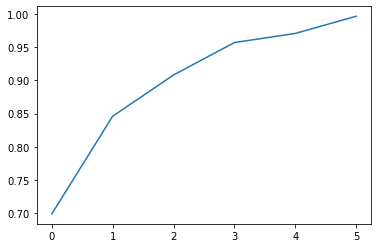

In [31]:
# Accuracy graph

accu = history.history['accuracy']
plt.plot(accu)

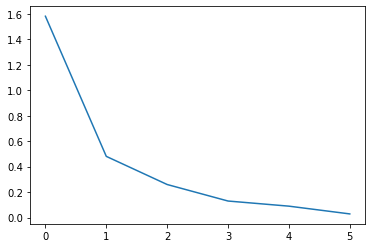

In [32]:
# Losses graph

losss = history.history['loss']
plt.plot(losss)

In [33]:
# Model accuracy

test_img_data = []
size = len(x_test)

for i in tqdm(range(size)):
    image = Image.open('C:/Users/Hp/PycharmProjects/HAR/train/' + x_test[i])
    test_img_data.append(np.asarray(image.resize((160,160))))

scores = model.evaluate(np.asarray(test_img_data), y_test)
print(f"Test Accuracy: {scores[1]}")

  0%|          | 0/420 [00:00<?, ?it/s]

14/14 [==============================] - 25s 2s/step - loss: 0.7731 - accuracy: 0.8167
Test Accuracy: 0.8166666626930237


In [35]:
# Function to read images as array

def read_image(fn):
    image = Image.open(fn)
    return np.asarray(image.resize((160,160)))

In [39]:
# Function to predict

def test_predict(test_image):
    result = model.predict(np.asarray([read_image(test_image)]))

    itemindex = np.where(result==np.max(result))
    prediction = classes[itemindex[1][0]]
    print("probability: "+str(np.max(result)*100) + "%\nPredicted class : ", prediction)
    engine.setProperty('rate', 100)
    engine.say(prediction)
    engine.runAndWait()
    image = img.imread(test_image)
    plt.imshow(image)
    plt.title(prediction)

# Customize Prediction using test images

1/1 [==============================] - 0s 175ms/step
probability: 100.0%
Predicted class :  running


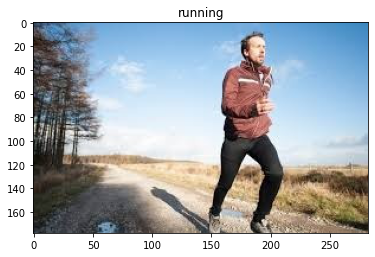

In [40]:
test_predict('C:/Users/Hp/PycharmProjects/HAR/test/Image_100.jpg')

1/1 [==============================] - 0s 178ms/step
probability: 99.96881484985352%
Predicted class :  clapping


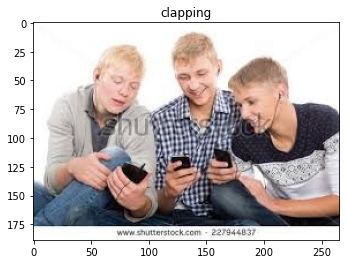

In [41]:
test_predict('C:/Users/Hp/PycharmProjects/HAR/test/Image_1010.jpg')


1/1 [==============================] - 0s 182ms/step
probability: 91.25210642814636%
Predicted class :  sitting


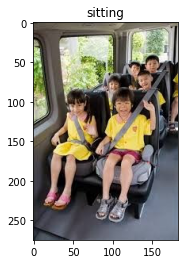

In [42]:
test_predict('C:/Users/Hp/PycharmProjects/HAR/test/Image_1345.jpg')

1/1 [==============================] - 0s 188ms/step
probability: 99.98772144317627%
Predicted class :  clapping


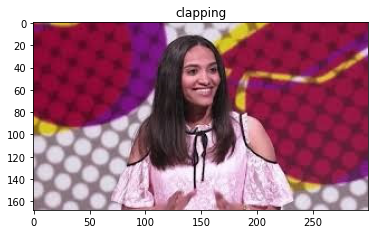

In [43]:
test_predict('C:/Users/Hp/PycharmProjects/HAR/test/Image_502.jpg')

In [44]:
from tensorflow.keras.models import Sequential, model_from_json

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 
# later...
 
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Saved model to disk
Loaded model from disk


1/1 [==============================] - 0s 162ms/step
probability: 97.2528874874115%
Predicted class :  clapping


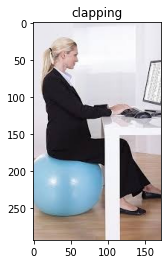

In [45]:
test_predict('C:/Users/HP/PycharmProjects/HAR/test/Image_104.jpg')

1/1 [==============================] - 0s 171ms/step
probability: 60.64491271972656%
Predicted class :  sleeping


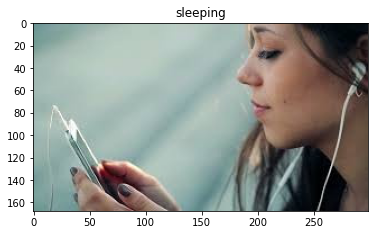

In [46]:
test_predict('C:/Users/Hp/PycharmProjects/HAR/test/Image_105.jpg')

1/1 [==============================] - 0s 181ms/step
probability: 99.99994039535522%
Predicted class :  sleeping


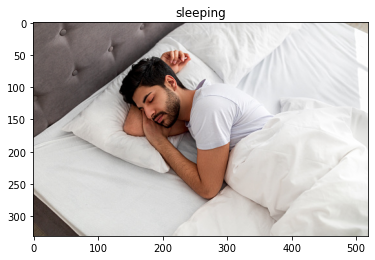

In [47]:
test_predict('C:/Users/Hp/PycharmProjects/HAR/test/sleeping.jpg')

1/1 [==============================] - 0s 181ms/step
probability: 94.12261843681335%
Predicted class :  eating


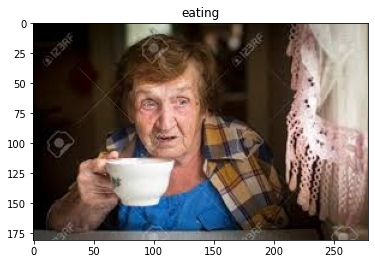

In [48]:
test_predict('C:/Users/Hp/PycharmProjects/HAR/test/Image_45.jpg')

1/1 [==============================] - 0s 172ms/step
probability: 91.25210642814636%
Predicted class :  sitting


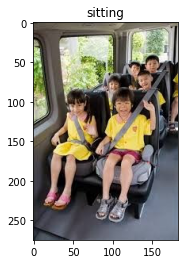

In [49]:
test_predict('C:/Users/Hp/PycharmProjects/HAR/test/Image_1345.jpg')

1/1 [==============================] - 0s 166ms/step
probability: 99.98772144317627%
Predicted class :  clapping


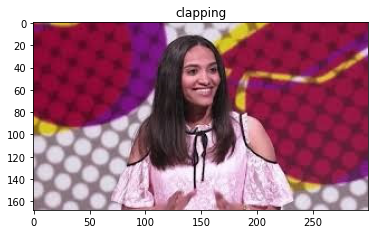

In [50]:
test_predict('C:/Users/Hp/PycharmProjects/HAR/test/Image_502.jpg')

import pickle

pickle.dump(model,open("HAR_Model.pkl",'wb'))